<a href="https://colab.research.google.com/github/saimsheikh123/cmpe258-project/blob/main/Vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TensorFlow Version: 2.19.0
✅ Legacy Keras configured. Proceed with the pipeline.


In [ ]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# --- CONFIGURATION: UPDATE THIS PATH ---
# Point this to where you uploaded the zip file in your Drive
ZIP_PATH = '/content/drive/MyDrive/Animals-10.zip'
# ---------------------------------------

# 2. Copy and Unzip to Local Colab Storage
if not os.path.exists('Animals-10'):
    print(f"Copying {ZIP_PATH} to local storage...")
    !cp "{ZIP_PATH}" animals-10.zip
    print("Unzipping...")
    !unzip -q animals-10.zip -d Animals-10
    print("Done.")

# 3. Find Images and Prepare Splits
DATA_DIR = 'Animals-10/raw-img'
if not os.path.exists(DATA_DIR):
    # Fallback to find the folder if the zip structure is different
    for root, dirs, files in os.walk('Animals-10'):
        if 'cane' in dirs:
            DATA_DIR = root
            break

class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print(f"Classes found: {class_names}")

image_paths = []
labels = []
class_to_index = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(DATA_DIR, class_name)
    for f in os.listdir(class_dir):
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_dir, f))
            labels.append(class_to_index[class_name])

# Stratified Split
X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths, labels, test_size=0.30, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Class Weights
class_weights_arr = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train
)
class_weights = {i: w for i, w in enumerate(class_weights_arr)}

# 4. Build ViT Data Pipeline
def process_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = (img / 127.5) - 1.0 # Normalize to [-1, 1]
    img = tf.transpose(img, [2, 0, 1]) # Channels First for HF
    return img, label

def build_dataset(paths, labels, is_training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        ds = ds.shuffle(len(paths))
    ds = ds.batch(32).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = build_dataset(X_train, y_train, is_training=True)
val_ds = build_dataset(X_val, y_val)
test_ds = build_dataset(X_test, y_test)
print("Data pipeline ready.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copying /content/drive/MyDrive/Animals-10.zip to local storage...
Unzipping...
Done.
Classes found: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Data pipeline ready.


In [ ]:
# 1. Define Image Processing
def process_image(image_path, label):
    # Load and Decode
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)

    # Resize to 224x224 (ViT Standard) [cite: 132]
    img = tf.image.resize(img, (224, 224))

    # Normalize to [-1, 1] for ViT
    img = (img / 127.5) - 1.0

    # Transpose to (Channels, Height, Width) format for Hugging Face
    img = tf.transpose(img, [2, 0, 1])
    return img, label

# 2. Build Dataset Function
def build_dataset(paths, labels, is_training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        ds = ds.shuffle(len(paths))

    ds = ds.batch(32) # [cite: 177]
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = build_dataset(X_train, y_train, is_training=True)
val_ds = build_dataset(X_val, y_val)
test_ds = build_dataset(X_test, y_test)

In [ ]:
from transformers import TFAutoModelForImageClassification
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, f1_score


MODEL_NAME = "google/vit-base-patch16-224-in21k"

model = TFAutoModelForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=10,
    id2label={i: c for i, c in enumerate(class_names)},
    label2id={c: i for i, c in enumerate(class_names)},
    from_pt=True # Load PyTorch weights
)


model.vit.trainable = False
model.compile(optimizer=Adam(1e-3), metrics=['accuracy'])

print("\n--- STAGE 1: WARM-UP ---")
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights
)


print("\n--- STAGE 2: FINE-TUNING ---")
model.vit.trainable = True


model.compile(optimizer=Adam(1e-5), metrics=['accuracy'])


callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('vit_best.h5', save_best_only=True, save_weights_only=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)


print("\n--- EXPERIMENT 3 RESULTS (ViT) ---")
logits = model.predict(test_ds).logits
preds = np.argmax(logits, axis=1)

print(classification_report(y_test, preds, target_names=class_names))
print(f"Weighted F1-Score: {f1_score(y_test, preds, average='weighted'):.4f}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should proba


--- STAGE 1: WARM-UP ---
Epoch 1/10
573/573 [==============================] - 327s 534ms/step - loss: 0.2857 - accuracy: 0.9829 - val_loss: 0.0768 - val_accuracy: 0.9870
Epoch 2/10
573/573 [==============================] - 312s 530ms/step - loss: 0.0615 - accuracy: 0.9898 - val_loss: 0.0557 - val_accuracy: 0.9878
Epoch 3/10
573/573 [==============================] - 312s 529ms/step - loss: 0.0474 - accuracy: 0.9910 - val_loss: 0.0490 - val_accuracy: 0.9885
Epoch 4/10
573/573 [==============================] - 311s 528ms/step - loss: 0.0400 - accuracy: 0.9920 - val_loss: 0.0471 - val_accuracy: 0.9885
Epoch 5/10
573/573 [==============================] - 312s 529ms/step - loss: 0.0347 - accuracy: 0.9933 - val_loss: 0.0448 - val_accuracy: 0.9891
Epoch 6/10
573/573 [==============================] - 311s 529ms/step - loss: 0.0305 - accuracy: 0.9941 - val_loss: 0.0441 - val_accuracy: 0.9891
Epoch 7/10
573/573 [==============================] - 312s 529ms/step - loss: 0.0271 - accuracy: 0

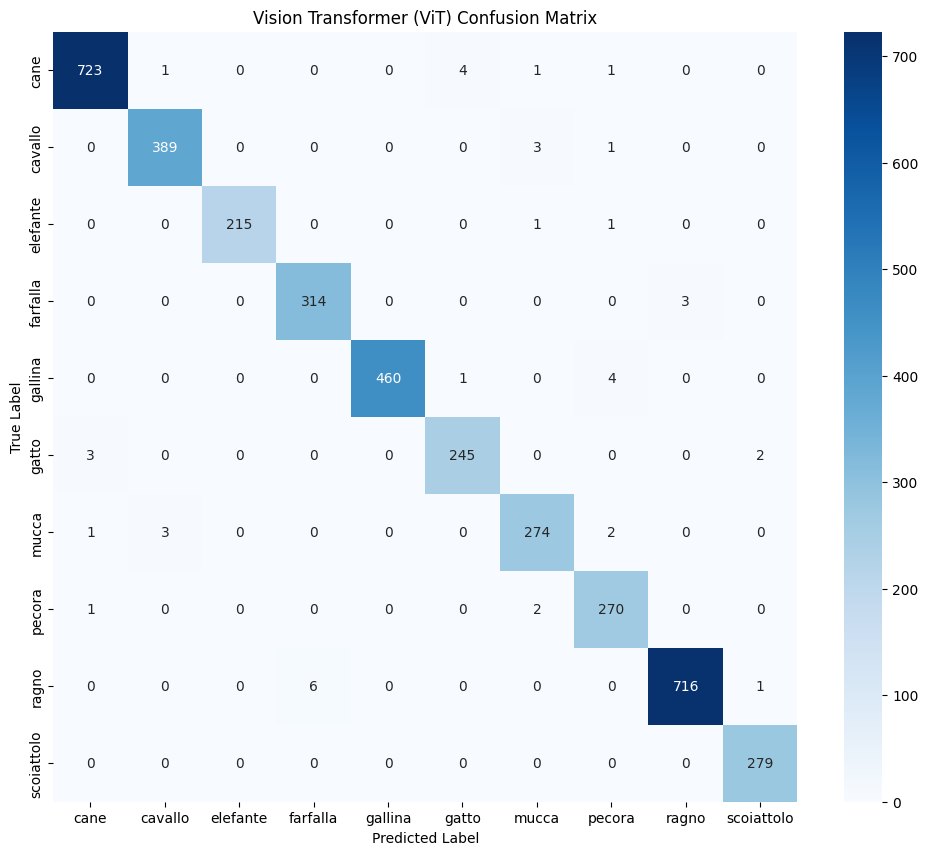

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Experiment 3: Vision Transformer (ViT) Confusion Matrix')
plt.show()